# Main Script

## Setup

In [ ]:
!pip install langchain
!pip install langchain-community
!pip install faiss-gpu
!pip install peft
!pip install transformers
!pip install ragas
!pip install llama_index
!pip install langchain-aws

In [20]:
import boto3

# Initialize a session using the default profile or environment credentials
session = boto3.Session()

In [1]:
import sys
import os

# Add the parent directory of the current working directory to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
print(os.getcwd())

/home/ec2-user/SageMaker/Fine_Tune_LLMs/Big


In [4]:
!pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 116.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3


In [7]:
!pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.9 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36


In [ ]:
!pip install faiss-gpu

In [8]:
import yaml
import boto3
import src
from src.document_processor.loader import DocumentLoader
from src.document_processor.chunker import DocumentChunker
from src.document_processor.cleaner import TextCleaner
from src.embeddings.embedding_manager import EmbeddingManager
from src.question_generation.generator import EnhancedQuestionGenerator
import logging


with open('/home/ec2-user/SageMaker/Fine_Tune_LLMs/Big/config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Setup logging
logging.basicConfig(
    level=getattr(logging, config['logging']['level']),
    format=config['logging']['format']
)

logger = logging.getLogger(__name__)

# Initialize AWS client
bedrock_client = boto3.client('bedrock-runtime')

# Initialize components
loader = DocumentLoader()
chunker = DocumentChunker(
    chunk_size=config['document_processing']['chunk_size'],
    chunk_overlap=config['document_processing']['chunk_overlap']
)
cleaner = TextCleaner()

embedding_manager = EmbeddingManager(
    bedrock_client,
    model_id=config['embedding']['model_id']
)

generator = EnhancedQuestionGenerator(
    llm_client=bedrock_client,
    model_id=config['question_generation']['model_id'],
    embedding_manager=embedding_manager,
    max_tokens=config['question_generation']['max_tokens'],
    temperature=config['question_generation']['temperature']
)

2024-11-20 10:50:49,523 - botocore.credentials - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
/home/ec2-user/SageMaker/Fine_Tune_LLMs/Big/src/embeddings/embedding_manager.py:13: LangChainDeprecationWarning: The class `BedrockEmbeddings` was deprecated in LangChain 0.2.11 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-aws package and should be used instead. To use it run `pip install -U :class:`~langchain-aws` and import as `from :class:`~langchain_aws import BedrockEmbeddings``.
  self.embeddings = BedrockEmbeddings(


In [ ]:
# Process documents
documents = loader.load_document("/home/ec2-user/SageMaker/Fine_Tune_LLMs/Big/data/NM_changed.pdf")
logger.info("Documents loaded")

# Clean and chunk documents
cleaned_documents = []
for doc in documents:
    doc.page_content = cleaner.clean_text(doc.page_content)
    cleaned_documents.append(doc)
logger.info("Documents cleaned")

chunks = chunker.chunk_documents(cleaned_documents)
logger.info(f"Documents chunked into {len(chunks)} chunks")

# Create embeddings
embedding_manager.create_embeddings(chunks)
logger.info("Embeddings created")

In [ ]:
# Create embeddings and save them
#embedding_manager.create_embeddings(documents)
embedding_manager.save_embeddings("faiss_index", "metadata.txt")

# Load the saved embeddings
#embedding_manager.load_embeddings("faiss_index")

# Wipe the existing database
#embedding_manager.wipe_embeddings("faiss_index", "metadata.txt")

In [ ]:
import pandas as pd
# Generate questions
questions = generator.generate_questions_from_docs(
    chunks,
    num_questions= 100
)
logger.info(f"{len(questions)} question-answer pairs generated")

# Prepare data for DataFrame
qa_data = [{"Question": qa.question, "Answer": qa.answer, "Context": qa.context} for qa in questions]

# Create DataFrame
qa_df = pd.DataFrame(qa_data)

In [9]:
# Display the DataFrame
qa_df.head()

NameError: name 'qa_df' is not defined

In [ ]:
# Display the DataFrame
qa_df.tail()

In [ ]:
qa_df.to_csv("qa_data.csv", index=False)

# Fine-tuning

## Ministral-3B-instruct

I'm going to test this model on really specific questions from the Nuclear Medicine manual and see how well it responds firs

In [10]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 153.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 146.8 MB/s eta 0:00:00


In [11]:
!pip install trl

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.17
    Uninstalling multiprocess-0.70.17:
      Successfully uninstalled multiprocess-0.70.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.3 requires dill>=0.3.9, but you have dill 0.3.8 which is incompatible.
pathos 0.3.3 requires multiprocess>=0.70.17, but you have multiprocess 0.70.16 which is incompatible.


In [12]:
!pip install transformers

In [13]:
# Required imports
!pip install ragas
!pip install llama_index
import torch
import ragas
from ragas.llms import LangchainLLMWrapper
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from ragas.testset import TestsetGenerator
from langchain_openai import ChatOpenAI
from llama_index.core import SimpleDirectoryReader
import gc
import pandas as pd
from datasets import Dataset

# Memory management class
class MemoryTracker:
    def __init__(self):
        self.records = []
    
    def log_memory(self, checkpoint):
        memory_stats = {
            'checkpoint': checkpoint,
            'allocated': torch.cuda.memory_allocated() / 1024**2,
            'reserved': torch.cuda.memory_reserved() / 1024**2
        }
        self.records.append(memory_stats)
        return memory_stats

    def clear_memory(self):
        torch.cuda.empty_cache()
        gc.collect()

memory_tracker = MemoryTracker()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


2024-11-20 10:54:41,581 - datasets - INFO - PyTorch version 2.2.2 available.


In [14]:
import torch
import gc

# Clear CUDA cache
torch.cuda.empty_cache()
# Run garbage collector
gc.collect()

19

In [15]:
def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

print_gpu_memory()

Allocated memory: 0.00 MB
Cached memory: 0.00 MB


## Generating answers based on the questions generated by Claude in the previous section

In [16]:
import pandas as pd
from transformers import pipeline

# Load questions from the CSV
qa_df = pd.read_csv("qa_data.csv")  # Replace with your CSV file path
questions = qa_df['Question'].tolist()  # Assuming 'question' is the column name

# Initialize the Mistral model pipeline
pipe = pipeline("text-generation", model="ministral/Ministral-3b-instruct", device = 0)

responses = []
for question in questions:
    messages = [{"role": "user", "content": question}]
    response = pipe(messages, max_new_tokens=600, do_sample=True, temperature = 0.4, top_p = 0.7)

    # Navigate the nested structure to extract the assistant's content
    try:
        generated_messages = response[0]['generated_text']
        assistant_message = next(
            (msg['content'] for msg in generated_messages if msg['role'] == 'assistant'), 
            "No assistant response found"
        )
        responses.append(assistant_message)
    except KeyError as e:
        print(f"KeyError: {e} in response {response}")
        responses.append("Error: Unexpected response format")

# Combine questions and responses
result_df = pd.DataFrame({'question': questions, 'mistral_response': responses})

# Save the results to a new CSV
result_df .to_csv("qa_with_mistral_responses.csv", index=False)

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/698M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/510 [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [17]:
qa_df = pd.read_csv("qa_data.csv")

In [18]:
qa_df.head()

,Question,Answer,Context
0,What is the fundamental concept and process in...,Nuclear medicine imaging involves administerin...,1 chapter What Is Nuclear Medicine?A. FUNDAMEN...
1,What are the current applications and global u...,"As of 2006, there were roughly 100 different d...",1 chapter What Is Nuclear Medicine?A. FUNDAMEN...
2,What are the two broad classes of nuclear medi...,The two broad classes of nuclear medicine imag...,photons are emitted. The energy of these gamma...
3,"What are the key components of a gamma camera,...",The key components of a gamma camera are a col...,photons are emitted. The energy of these gamma...
4,What are the two broad classes of nuclear medi...,The two broad classes of nuclear medicine imag...,particular angle. This results in an image wit...


In [22]:
!pip install langchain-aws

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
qa_df = pd.read_csv("qa_data.csv")
result_df = pd.read_csv("qa_with_mistral_responses.csv")

## Metrics: 

- `Faithfulness` metric measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. Higher the better.
- `FactualCorrectness` is a metric that compares and evaluates the factual accuracy of the generated response with the reference.
- `Semantic Similarity` pertains to the assessment of the semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.

In [56]:
# Import necessary modules
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import Faithfulness, FactualCorrectness, SemanticSimilarity
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_aws import ChatBedrockConverse
from langchain_aws import BedrockEmbeddings

# AWS Bedrock configuration
config = {
    "llm": "anthropic.claude-3-sonnet-20240229-v1:0",
    "embeddings": "amazon.titan-embed-text-v1",
    "temperature": 0.4,
}

# Initialize Bedrock evaluator models
evaluator_llm = LangchainLLMWrapper(ChatBedrockConverse(
    model=config["llm"],
    temperature=config["temperature"],
))

evaluator_embeddings = LangchainEmbeddingsWrapper(BedrockEmbeddings(
    model_id=config["embeddings"],
))

2024-11-20 14:12:24,504 - botocore.credentials - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
2024-11-20 14:12:24,577 - botocore.credentials - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [57]:
# Create dataset dictionary
dataset_dict_1 = {
    "question": qa_df['Question'].tolist()[:8],
    "answer": result_df['mistral_response'].tolist()[:8],
    "ground_truth": qa_df['Answer'].tolist()[:8],
    "retrieved_contexts": [[context] if isinstance(context, str) else context 
                         for context in qa_df['Context'].tolist()[:8]]
}
ragas_dataset_1 = Dataset.from_dict(dataset_dict_1)

metrics = [
    FactualCorrectness(llm=evaluator_llm), 
    Faithfulness(llm=evaluator_llm),
    SemanticSimilarity(embeddings=evaluator_embeddings),
]

results_mistral = evaluate(
    dataset=ragas_dataset_1,
    metrics=metrics
)

# Display results
print("Evaluation Results:", results_mistral)

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

2024-11-20 14:12:59,900 - ragas.executor - ERROR - Exception raised in Job[13]: AttributeError('StringIO' object has no attribute 'sentences')
2024-11-20 14:15:25,966 - ragas.executor - ERROR - Exception raised in Job[1]: TimeoutError()
2024-11-20 14:15:25,967 - ragas.executor - ERROR - Exception raised in Job[4]: TimeoutError()
2024-11-20 14:15:25,968 - ragas.executor - ERROR - Exception raised in Job[7]: TimeoutError()
2024-11-20 14:15:26,469 - ragas.executor - ERROR - Exception raised in Job[16]: TimeoutError()
2024-11-20 14:15:26,832 - ragas.executor - ERROR - Exception raised in Job[19]: TimeoutError()
2024-11-20 14:15:32,520 - ragas.executor - ERROR - Exception raised in Job[22]: TimeoutError()


Evaluation Results: {'factual_correctness': 0.0400, 'faithfulness': 0.0000, 'semantic_similarity': 0.4264}


2024-11-20 14:16:33,823 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: bedrock-runtime.us-east-1.amazonaws.com. Connection pool size: 10
2024-11-20 14:16:35,571 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: bedrock-runtime.us-east-1.amazonaws.com. Connection pool size: 10


In [44]:
results_mistral.head()

,user_input,retrieved_contexts,response,reference,factual_correctness,faithfulness,semantic_similarity
0,What is the fundamental concept and process in...,[1 chapter What Is Nuclear Medicine?A. FUNDAME...,Nanomicroscopy is a technique used to observe ...,Nuclear medicine imaging involves administerin...,0.0,NaN,0.219188
1,What are the current applications and global u...,[1 chapter What Is Nuclear Medicine?A. FUNDAME...,Nanomicrobiology is a branch of biology that u...,"As of 2006, there were roughly 100 different d...",0.0,0.0,0.211713
2,What are the two broad classes of nuclear medi...,[photons are emitted. The energy of these gamm...,1. Imaging of Nuclear Vitamins and Vitamins:\n...,The two broad classes of nuclear medicine imag...,0.0,0.0,0.553157
3,"What are the key components of a gamma camera,...",[photons are emitted. The energy of these gamm...,1. Aperture: The size of the lens at the cente...,The key components of a gamma camera are a col...,0.0,0.0,0.313325
4,What are the two broad classes of nuclear medi...,[particular angle. This results in an image wi...,1. Imaging of the MRI MRI MRI MRI MRI MRI MRI ...,The two broad classes of nuclear medicine imag...,0.0,NaN,0.314468


In [37]:
# Create dataset dictionary
dataset_dict_2 = {
    "question": qa_df['Question'].tolist()[:8],
    "answer": qa_df['Answer'].tolist()[:8],
    "ground_truth": qa_df['Answer'].tolist()[:8],
    "retrieved_contexts": [[context] if isinstance(context, str) else context 
                         for context in qa_df['Context'].tolist()[:8]]
}
ragas_dataset_2 = Dataset.from_dict(dataset_dict_2)

metrics = [
    FactualCorrectness(llm=evaluator_llm), 
    Faithfulness(llm=evaluator_llm),
    SemanticSimilarity(embeddings=evaluator_embeddings)
]

results_claude = evaluate(
    dataset=ragas_dataset_2,
    metrics=metrics
)

# Display results
print("Evaluation Results:", results)

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluation Results: {'factual_correctness': 1.0000, 'faithfulness': 0.9643, 'semantic_similarity': 1.0000}


In [45]:
results_claude.head()

,user_input,retrieved_contexts,response,reference,factual_correctness,faithfulness,semantic_similarity
0,What is the fundamental concept and process in...,[1 chapter What Is Nuclear Medicine?A. FUNDAME...,Nuclear medicine imaging involves administerin...,Nuclear medicine imaging involves administerin...,1.0,1.000000,1.0
1,What are the current applications and global u...,[1 chapter What Is Nuclear Medicine?A. FUNDAME...,"As of 2006, there were roughly 100 different d...","As of 2006, there were roughly 100 different d...",1.0,1.000000,1.0
2,What are the two broad classes of nuclear medi...,[photons are emitted. The energy of these gamm...,The two broad classes of nuclear medicine imag...,The two broad classes of nuclear medicine imag...,1.0,0.888889,1.0
3,"What are the key components of a gamma camera,...",[photons are emitted. The energy of these gamm...,The key components of a gamma camera are a col...,The key components of a gamma camera are a col...,1.0,0.909091,1.0
4,What are the two broad classes of nuclear medi...,[particular angle. This results in an image wi...,The two broad classes of nuclear medicine imag...,The two broad classes of nuclear medicine imag...,1.0,1.000000,1.0


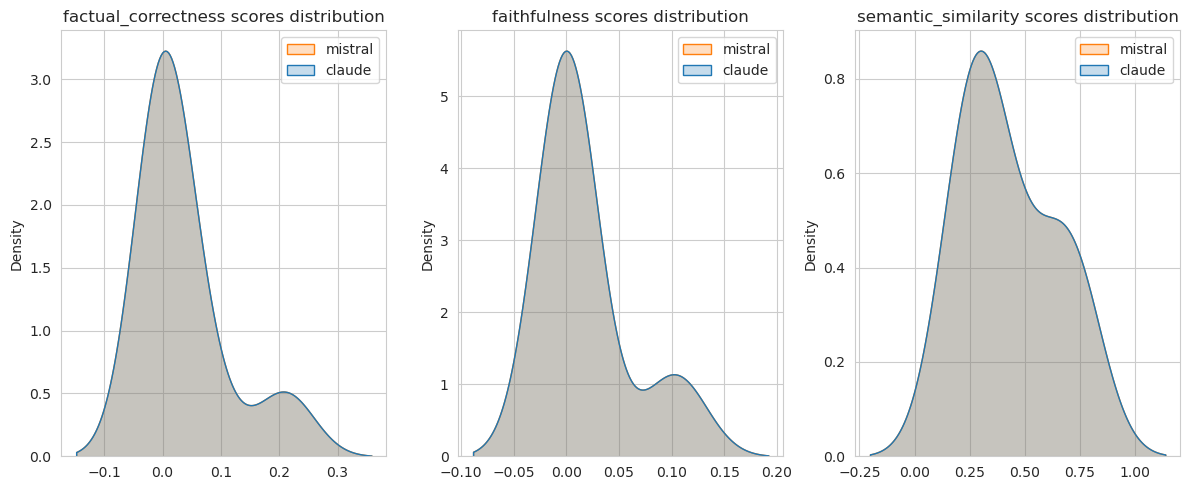

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analysis(mistral_df, claude_df):
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    
    for i, col in enumerate(mistral_df.columns):
        sns.kdeplot(
            data=[mistral_df[col].values, claude_df[col].values],
            legend=False,
            ax=axs[i],
            fill=True
        )
        axs[i].set_title(f'{col} scores distribution')
        axs[i].legend(labels=["mistral", "claude"])
    
    plt.tight_layout()
    plt.show()

# Call the analysis function
analysis(
    results_mistral[['factual_correctness', 'faithfulness', 'semantic_similarity']],
    results_mistral[['factual_correctness', 'faithfulness', 'semantic_similarity']])


Obviously the results of comparing claude answers to claude answers will be perfect, this is just to test if the evaluation is working correctly. After, we will fill tune the mistral model and check again! 

## Fine tune using PEFT - LORA

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer